# ASAXS data reduction

some script description

## Libraries

In [21]:
import pandas as pd
import os
import csv
import time

import numpy as np
from scipy import optimize
import scipy.constants as con
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

import fabio
import pyFAI
from pyFAI.detectors import Pilatus1M

## Fuctions

In [22]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1.0, 0.7, 0.7))
         }
red_alpha = LinearSegmentedColormap('red_alpha', cdict)
plt.register_cmap(cmap=red_alpha)

## Read the basic data

In [23]:
# give the directory
data_dir = 'files\Data_for_ASAXS'
# name if data file ontaining all nessesary information
metaFileName = 'Data_for_ASAXS_ASCII_out_changed_test.txt'

#read the meta file
path_to_metaFile = data_dir + os.sep + metaFileName
metaFrame = pd.read_csv(path_to_metaFile, sep='\t',index_col=0)

# Define divice identifiers
sampleName = 'SampleName'
monitorDiode = 'Keysight4'
monitorDeviation = 'Keysight4:StandardDeviation'
transmissionDiode = 'Keysight1'
transmissionDeviation = 'Keysight1:StandardDeviation'
acquisitionTime = 'PilatusAcqTime'
sampleThickness = 'SampleThickness'
sampleName = 'SampleName'

In [24]:
tiffName = metaFrame['Pilatus_filename'][0].split('/')[-1]
tiffPath = data_dir + os.sep + tiffName
energy = metaFrame['Energy'][0]
print(tiffPath, energy)


files\Data_for_ASAXS\pilatus_2020kw29tg14_00378.tif 7000.002692


## Data Handling

In [25]:
usedBackGr_index = 'False'
usedReference_index = 'False'
correctionFrame = pd.DataFrame()

for element in metaFrame.index:
    # read the image
    tiffName = metaFrame['Pilatus_filename'][element].split('/')[-1]
    tiffPath = data_dir + os.sep + tiffName
    image_object = fabio.open(tiffPath)
    image = image_object.data
    
    # read values
    name = metaFrame[sampleName][element]
    monitorI = metaFrame[monitorDiode][element]
    transmI = metaFrame[transmissionDiode][element]
    monitorI_dev = metaFrame[monitorDeviation][element]
    transmI_dev = metaFrame[transmissionDeviation][element]
    acqTime = metaFrame[acquisitionTime][element]
    thickness = metaFrame[sampleThickness][element]
    
    empty_monitorI = metaFrame[monitorDiode][metaFrame['Empty_Index'][element]]
    empty_transmI = metaFrame[transmissionDiode][metaFrame['Empty_Index'][element]]
    
    # calculate transmission
    image_transmission = (transmI/monitorI)/(empty_transmI/empty_monitorI)
    image_transmission_deviation = image_transmission * (monitorI_dev/monitorI + transmI_dev/transmI)
    #print(tiffName,'measured',acqTime,'sec with transmission:' , image_transmission, '+/-',image_transmission_deviation)
    
    # normalizing image
    image = image / monitorI / acqTime / image_transmission
    
    # loead the image background file
    if int(metaFrame['Background_Index'][element]) == usedBackGr_index:
        print('stay')
        pass
    else:
        # read the BackGround image
        tiffName_BackGr = metaFrame['Pilatus_filename'][metaFrame['Background_Index'][element]].split('/')[-1]
        tiffPath_BackGr = data_dir + os.sep + tiffName_BackGr
        image_object_BackGr = fabio.open(tiffPath_BackGr)
        image_BackGr = image_object_BackGr.data
        usedBackGr_index = int(metaFrame['Background_Index'][element])
        
        # read BackGround values
        monitorI_BG = metaFrame[monitorDiode][usedBackGr_index]
        transmI_BG = metaFrame[transmissionDiode][usedBackGr_index]
        monitorI_BG_dev = metaFrame[monitorDeviation][usedBackGr_index]
        transmI_BG_dev = metaFrame[transmissionDeviation][usedBackGr_index]
        acqTime_BG = metaFrame[acquisitionTime][usedBackGr_index]
        empty_monitorI_BG = metaFrame[monitorDiode][metaFrame['Empty_Index'][usedBackGr_index]]
        empty_transmI_BG = metaFrame[transmissionDiode][metaFrame['Empty_Index'][usedBackGr_index]]
        
        # calculate BackGround transmission
        image_transmission_BG = (transmI_BG/monitorI_BG)/(empty_transmI_BG/empty_monitorI_BG)
        image_transmission_BG_deviation = image_transmission_BG * (monitorI_BG_dev/monitorI_BG + transmI_BG_dev/transmI_BG)
        
        # normalizing BackGround image
        image_BackGr = image_BackGr / monitorI_BG / acqTime_BG / image_transmission_BG
        print(usedBackGr_index,'=',image_transmission_BG,'+/-',image_transmission_BG_deviation)
    
    # Subtract the scattering Background
    image = image - image_BackGr
    image = image/thickness
    
    # loead the image Reference file
    if int(metaFrame['Reference_Index'][element]) == usedReference_index:
        #print('stay')
        pass
    else:
        usedReference_index = int(metaFrame['Reference_Index'][element])
        # read the Reference image
        tiffName_Ref = metaFrame['Pilatus_filename'][metaFrame['Reference_Index'][usedReference_index]].split('/')[-1]
        tiffPath_Ref = data_dir + os.sep + tiffName_Ref
        image_object_Ref = fabio.open(tiffPath_Ref)
        image_Ref = image_object_Ref.data
        
        tiffName_Empty = metaFrame['Pilatus_filename'][metaFrame['Empty_Index'][usedReference_index]].split('/')[-1]
        tiffPath_Empty = data_dir + os.sep + tiffName_Ref
        image_object_Empty = fabio.open(tiffPath_Empty)
        image_Empty = image_object_Empty.data
        
        #print('Reference is:',tiffName_Ref,'| Empty is:', tiffName_Empty)
        
        # read Reference values
        monitorI_Ref = metaFrame[monitorDiode][usedReference_index]
        transmI_Ref = metaFrame[transmissionDiode][usedReference_index]
        monitorI_Ref_dev = metaFrame[monitorDeviation][usedReference_index]
        transmI_Ref_dev = metaFrame[transmissionDeviation][usedReference_index]
        acqTime_Ref = metaFrame[acquisitionTime][usedReference_index]
        
        empty_monitorI_Ref = metaFrame[monitorDiode][metaFrame['Empty_Index'][usedReference_index]]
        empty_transmI_Ref = metaFrame[transmissionDiode][metaFrame['Empty_Index'][usedReference_index]]
        empty_acqTime = metaFrame[acquisitionTime][metaFrame['Empty_Index'][usedReference_index]]
        
        # calculate Reference and Reference-BackGround transmission
        image_transmission_Ref = (transmI_Ref/monitorI_Ref)/(empty_transmI_Ref/empty_monitorI_Ref)
        image_transmission_Ref_deviation = image_transmission_Ref * (monitorI_Ref_dev/monitorI_Ref + transmI_Ref_dev/transmI)
        
        image_transmission_Empty = (empty_transmI_Ref/empty_monitorI_Ref)/(empty_transmI_Ref/empty_monitorI_Ref)
        
        
        # normalizing Reference image
        image_Ref = image_Ref / monitorI_Ref / acqTime_Ref / image_transmission_Ref
        image_Empty = image_Empty / empty_monitorI_Ref / empty_acqTime / image_transmission_Ref
        image_Ref = image_Ref - image_Empty
        
        #Do the azimutal integration of the Reference file
        
    correctionFrame = correctionFrame.append({'SampleName_Reduction':name,'Transm':image_transmission, 'TransmDev':image_transmission_deviation,'BackGrTransm':image_transmission_BG,'ReferenceTransm':image_transmission_Ref},ignore_index=True)       
    #fig, ax = plt.subplots()
    #ax.imshow(image, norm=LogNorm())
    
outputFrame = metaFrame.join(correctionFrame)

0 = 1.0 +/- 0.002322898396343198
stay
stay
stay
stay
3 = 0.6333670992319331 +/- 0.006531416362882512
stay
stay
stay
stay
stay
stay
16 = 0.6423077194384068 +/- 0.00434167234169353
stay
stay
stay
0 = 1.0 +/- 0.002322898396343198
stay


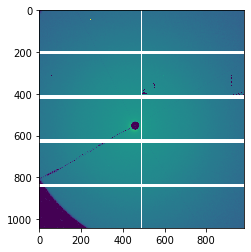

In [36]:
fig, ax = plt.subplots()
ax.imshow(image_Ref, norm=LogNorm())

In [29]:
x_Center = metaFrame['x_Center'][0]# 456.736 #pix
y_Center = metaFrame['y_Center'][0]#556.579 #pix
directBeamDistance = 801.690 #mm
dist = directBeamDistance / 1000 #m
# give the pixel size in meter
pixelsize = 172e-6 #m
energy = 7000 # in eV
#calculate wavelength, scattering angle and sample to detector distance
wavelength = con.h * con.c / con.e / energy  # m
print(energy,'eV correspond to',wavelength*(10**9),'nm','at a distance of',dist,'m')

7000 eV correspond to 0.1771202819948674 nm at a distance of 0.80169 m


In [35]:
# adress the mask
ai = pyFAI.AzimuthalIntegrator(dist=dist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,
                               detector=Pilatus1M(), wavelength=wavelength)

ai_mask_path = data_dir + os.sep + 'mask_short.edf'
ai_mask_object = fabio.open(ai_mask_path)
ai_mask = ai_mask_object.data


  File "<ipython-input-35-38ae0fef2851>", line 3, in <module>
    detector=Pilatus1M(), wavelength=wavelength)


In [37]:
# usage of integrate 1d method
bin_number = 400 #how many data points are generated
q, I, e = ai.integrate1d(image_Ref, bin_number, error_model='poisson', mask=ai_mask)

[]

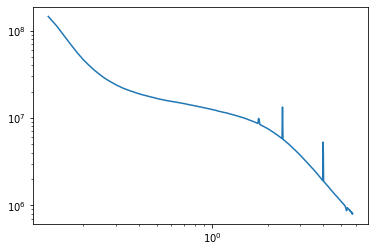

In [39]:
# Display the azimuthal integration result
scale = 10  # upscaling of poisson error for visibility

fig, ax = plt.subplots()
ax.fill_between(q, I + scale * e, I - scale * e, alpha=0.5)
ax.plot(q, I)
ax.loglog()
#ax.set_xlim([0.05, 1.81])

In [14]:
metaFrame

,Time,VacSampleX,VacSampleY,Energy,Pilatus_Tiff,Pilatus_Trigger,Pilatus_filename,PilatusAcqTime,Keysight1,Keysight2,...,PilatusPos,SampleName,SampleThickness,Empty_Index,Background_Index,Reference_Index,MaskFile,x_Center,y_Center,SampleToDet_Distance[m]
0,34.827,133.00,-1.100000e-05,7000.002692,378,379,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,2.299318e-06,5.430643e-10,...,3012.874,Empty,1.000,0,0,1,mask_short.edf,456.736,556.579,0.80169
1,639.834,123.00,-4.000000e-06,7000.002692,379,380,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,2.152853e-06,5.432002e-10,...,3012.874,GC,0.009,0,0,1,mask_short.edf,456.736,556.579,0.80169
2,944.835,113.00,4.163336e-17,7000.002692,380,381,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,10,1.337529e-06,5.675809e-10,...,3012.874,AgBeh,0.020,0,0,1,mask_short.edf,456.736,556.579,0.80169
3,963.534,88.16,1.000000e-06,7000.002692,381,382,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,1.448823e-06,5.820030e-10,...,3012.874,Empty Cap,0.100,0,0,1,mask_short.edf,456.736,556.579,0.80169
4,1567.693,83.10,4.163336e-17,7000.002692,382,383,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,9.860936e-07,5.657099e-10,...,3012.874,Hexane Cap,0.100,0,0,1,mask_short.edf,456.736,556.579,0.80169
5,2171.456,78.56,4.163336e-17,7000.002692,383,384,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,1.043859e-06,5.645524e-10,...,3012.874,223,0.100,0,3,1,mask_short.edf,456.736,556.579,0.80169
6,2475.185,73.03,3.000000e-06,7000.002692,384,385,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,1.063286e-06,5.681104e-10,...,3012.874,214neu,0.100,0,3,1,mask_short.edf,456.736,556.579,0.80169
7,2778.932,68.59,4.163336e-17,7000.002692,385,386,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,420,1.077293e-06,5.622022e-10,...,3012.874,211,0.100,0,3,1,mask_short.edf,456.736,556.579,0.80169
8,3202.678,63.33,4.163336e-17,7000.002692,386,387,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,1.053144e-06,5.493872e-10,...,3012.874,187,0.100,0,3,1,mask_short.edf,456.736,556.579,0.80169
9,3806.631,57.94,1.000000e-06,7000.002692,387,388,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,1.020712e-06,5.435593e-10,...,3012.874,193,0.100,0,3,1,mask_short.edf,456.736,556.579,0.80169
